# Random Forest Tree
Haytham Mohamed

INFS 890 - Spring 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [2]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

#data_file = 'order_flow_cleanup_data.csv'
data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'



test_split = 0.1

In [3]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [4]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
0,0.0700,0.0200,0.0100,0.0200,0.0200,0.0100,0.0100,0.1200,0.1600,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.1800,0.4000,0.6325
1,0.0600,0.0300,0.0100,0.0200,0.0200,0.0100,0.0100,0.1400,0.1700,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.1800,0.4400,0.6245
2,0.0600,0.0300,0.0100,0.0200,0.0200,0.0100,0.0100,0.1500,0.1400,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.1500,0.3600,0.6164
3,0.0900,0.0300,0.0100,0.0200,0.0200,0.0100,0.0100,0.0600,0.1900,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.5400,0.4000,0.5568
4,0.1100,0.0400,0.0100,0.0300,0.0300,0.0100,0.0100,0.1100,0.3200,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.3500,0.7800,0.5292


In [5]:
data.shape

(1499, 18)

In [6]:
targets = data['orders_ltcy']

inputs = data.drop(['orders_ltcy'], axis=1)
#inputs = inputs.drop(['date'], axis=1)

n_features = inputs.values.shape[1]

#inputs_scaled = scaler.fit_transform(inputs)
#x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max

print("there are {} features".format(n_features))

there are 17 features


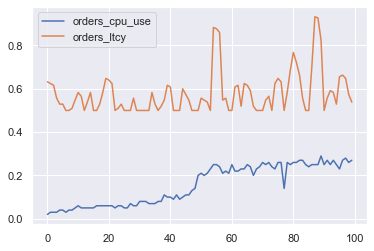

In [7]:
#plt.scatter(data['orders_cpu_use'], data['orders_ltcy'])
#plt.xlabel('orders_cpu_use', size=18)
#plt.ylabel("orders_ltcy", size=18)
#plt.show()

# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][:100], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][:100], label='orders_ltcy')
plt.legend()
plt.show()

#ax = sns.regplot(x=data['orders_cpu_use'], y=data['orders_ltcy'], color='g')


# Model

In [8]:
# start:  search grid

reg = RandomForestRegressor()

# standardize the features
scaler = StandardScaler()
#scaler.fit(x_train.values.reshape(-1,n_features))

#model = LassoCV(fit_intercept=False,n_jobs=-1,random_state=0,selection='random',positive=False,cv=10)
model = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=20)
sfm = SelectFromModel(model)


pipe = Pipeline(steps=[
    ('selector', sfm),
    ('scaler', scaler), 
    ('reg', reg)
])

kfold = KFold(n_splits=10, shuffle=True)

param_grid = {
    #'selector__threshold': [0.1, 0.05, 0.02, 0.001]  # with lasso
    'selector__threshold': ['1*mean', '0.8*mean', '0.6*mean', '0.3*mean', '0.1*mean','0.05*mean', '0.02*mean', '0.01*mean', '0.001*mean'] # with tree
    , 'reg__max_features': [11, 9, 7, 5, 3]   # The maximum number of features to consider
    , 'reg__n_estimators': [10, 8, 6, 4, 2, 1]  # The number of trees in the forest 
}

search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=1, n_jobs=-1)

#scores = cross_val_score(pipe, x_train, y_train, cv=kfold, n_jobs=-1
        #, verbose=3, scoring='neg_mean_squared_error')



In [9]:
import sklearn 
print(sklearn.__version__)

search.fit(x_train, y_train)

0.22.2.post1
Fitting 10 folds for each of 270 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:  2.3min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selector',
                                        SelectFromModel(estimator=RandomForestRegressor(bootstrap=True,
                                                                                        ccp_alpha=0.0,
                                                                                        criterion='mse',
                                                                                        max_depth=10,
                                                                                        max_features='auto',
                                                                                        max_leaf_nodes=None,
                                                                                        max_samples=None,
                                                                  

# Best Model

In [10]:
estimator = search.best_estimator_

score = search.best_score_
print("Best CV test score = %0.4f:" % score)

params = search.best_params_
print("Best CV params = {}".format(params))

print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")

print('mean train scores')
print(all_training_scores['mean_train_score'])

print('mean test scores')
print(all_training_scores['mean_test_score'])


Best CV test score = -0.0120:
Best CV params = {'reg__max_features': 9, 'reg__n_estimators': 10, 'selector__threshold': '0.02*mean'}

mean train scores
[        nan         nan         nan         nan         nan         nan
 -0.00220068 -0.0022559  -0.0022617          nan         nan         nan
         nan         nan         nan -0.00239011 -0.00241378 -0.00240541
         nan         nan         nan         nan         nan         nan
 -0.00269342 -0.00265842 -0.00283775         nan         nan         nan
         nan         nan         nan -0.0032934  -0.00312674 -0.00324707
         nan         nan         nan         nan         nan         nan
 -0.00503123 -0.00497905 -0.00500524         nan         nan         nan
         nan         nan -0.00851506 -0.00839916 -0.00860887 -0.00861363
         nan         nan         nan         nan -0.00224847 -0.00230539
 -0.00219327 -0.00221294 -0.00224621         nan         nan         nan
         nan -0.00249292 -0.00241246 -0.00237

# Features Selected

In [11]:
best_threshold = params['selector__threshold']

print('best selector threshold {}'.format(best_threshold))

#sfm = SelectFromModel(clf,threshold=best_threshold)

sfm = pipe['selector']
sfm.threshold = best_threshold

selectedFeatures = sfm.fit(x_train, y_train).transform(x_train)
print('{} features selected'.format(selectedFeatures[1].shape[0]))

feature_list = x_train.columns[sfm.get_support()]
features = ''
features = ', '.join(feature_list)
#features

reduced_x_train = x_train[feature_list]
#reduced_x_train.head(2)
print('')
for feature in reduced_x_train.columns.values:
    print(feature)

best selector threshold 0.02*mean
17 features selected

front-end_cpu_use
orders_cpu_use
orders-db_cpu_use
user_cpu_use
user-db_cpu_use
shipping_cpu_use
payment_cpu_use
carts_cpu_use
carts-db_cpu_use
front-end_pods
orders_pods
user_pods
shipping_pods
payment_pods
carts_pods
nodes_cpu_use
orders_req


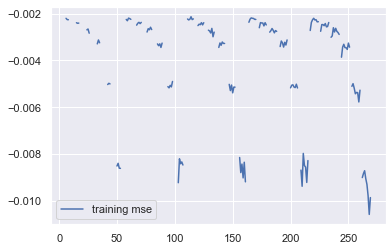

In [12]:
pdf = pd.DataFrame(all_training_scores['mean_train_score'], columns=['training mse'])
pdf.plot()

# Training R2

In [13]:
y_hat = estimator.predict(x_train)

r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))

#print("score ", search.score(x_test, y_test))
# or also R-Squared could be obtain via
#pline.score(x_train, y_train)

R2 (training) = 0.9500915290371227


In [14]:
print('Score (training) = {}'.format(search.score(x_train,y_train)))

Score (training) = -0.0023774720501033683


In [15]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.03 (0.04) 0.00 0.37 MSE


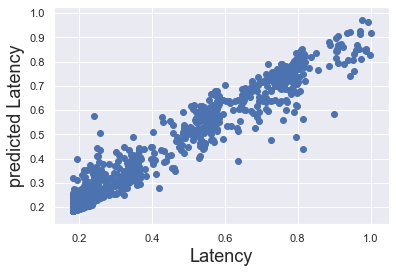

In [16]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

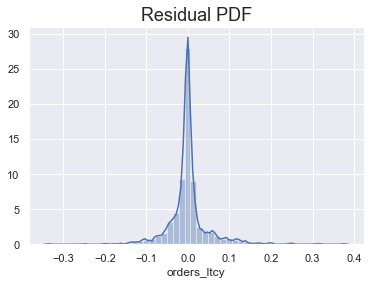

In [17]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

# Testing

In [18]:
y_hat_test = estimator.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

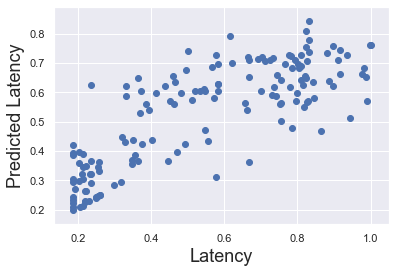

In [19]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

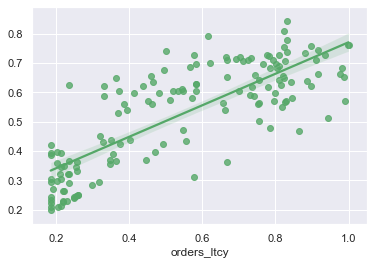

In [20]:
ax = sns.regplot(x=y_test, y=y_hat_test, color='g')

In [21]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,1.2182,1.2048
1,1.2526,1.2467
2,1.3794,1.2658
3,1.2723,1.2840
4,1.2730,1.2840


In [22]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,1.2182,1.2048,0.0134,1.1122
1,1.2526,1.2467,0.0059,0.4726
2,1.3794,1.2658,0.1136,8.9752
3,1.2723,1.2840,-0.0117,0.9105
4,1.2730,1.2840,-0.0110,0.8598
...,...,...,...,...
145,1.6500,2.1268,-0.4768,22.4191
146,2.1453,2.7126,-0.5674,20.9155
147,2.1040,2.5009,-0.3970,15.8728
148,1.9173,2.6881,-0.7707,28.6722


In [23]:
perf.describe()

,prediction,target,residual,difference%
count,150.0000,150.0000,150.0000,150.0000
mean,1.7189,1.7858,-0.0670,12.4114
std,0.2895,0.4596,0.3012,9.2303
min,1.2182,1.2048,-0.9209,0.0589
25%,1.4437,1.2981,-0.2560,4.9810
50%,1.7826,1.7370,0.0028,10.9783
75%,1.9387,2.2090,0.1357,18.8608
max,2.3266,2.7183,0.6046,47.7662


In [24]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
39,1.26,1.26,0.00,0.06
15,1.24,1.24,-0.00,0.11
21,1.23,1.23,0.00,0.18
9,1.44,1.44,0.00,0.23
129,2.03,2.04,-0.01,0.42
1,1.25,1.25,0.01,0.47
71,1.43,1.42,0.01,0.51
4,1.27,1.28,-0.01,0.86
3,1.27,1.28,-0.01,0.91
5,1.28,1.29,-0.01,0.97


# *** Prediction Accuracy

In [25]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.6176008429145852


In [26]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.15981330751836942
